### first we read our data from google drive

In [1]:
!pip install gdown


In [2]:
import gdown

file_id = '1UcK0JCyODND2pkhapuZUlMDtv9QgnViA'
output = '/content/alexa.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1UcK0JCyODND2pkhapuZUlMDtv9QgnViA
To: /content/alexa.zip
100%|██████████| 21.2M/21.2M [00:01<00:00, 18.5MB/s]


'/content/alexa.zip'

unzipping data

In [3]:
import zipfile

zip_path = "/content/alexa.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/alexa_data")

print("Data extracted successfully!")


Data extracted successfully!


checking whether it exists on our directory

In [4]:
import os

data_directory = '/content/alexa_data'

for root, dirs, files in os.walk(data_directory):
    print(root, "contains", len(files), "files")
    for file in files[:5]:
        print(file)


/content/alexa_data contains 0 files
/content/alexa_data/negative contains 350 files
9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_727d63da0efe8f7f069d094eed8741d5_sauro_1ce58107-d0aa-4b79-bf7c-5114f6dd93c3_1607977573543.wav
9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_727d63da0efe8f7f069d094eed8741d5_sauro_cb5cea2b-7d89-4764-b0db-a61bce98f575_1607974692717.wav
not-wakeword-es-88095a4a-bf56-11e9-8db3-bf37d8f5664b.wav
9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_727d63da0efe8f7f069d094eed8741d5_sauro_1ce58107-d0aa-4b79-bf7c-5114f6dd93c3_1607977543768.wav
not-wakeword-es-f414243c-bf55-11e9-b0b1-6388a807a6a6.wav
/content/alexa_data/positive contains 127 files
109.wav
189.wav
44.wav
103.wav
201.wav
/content/alexa_data/__MACOSX contains 2 files
._positive
._negative
/content/alexa_data/__MACOSX/negative contains 350 files
._not-wakeword-es-29e79026-bf56-11e9-8654-97918f88856f.wav
._0a977721-6fae-4eae-baa0-434888e0c802

## In the not augmented case

Firts extracting features and preprocess it

In [5]:
import librosa
import numpy as np
import os

def extract_features(file_path):
    """
    Extracting MFCC features from an audio file.

    :param file_path: Path to the audio file.
    :return: Extracted MFCC features.
    """
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def preprocess_and_extract(directory, output_file):

    features = []
    labels = []

    for subdir, _, files in os.walk(directory):
        if "__MACOSX" in subdir:
            continue  # we skip the   __MACOSX directory
        for file in files:
            if file.endswith(".wav") and not file.startswith("._"):
                file_path = os.path.join(subdir, file)
                print(f"Processing file: {file_path}")
                feature = extract_features(file_path)
                if feature is not None:
                    label = 1 if "positive" in subdir else 0
                    features.append(feature)
                    labels.append(label)

    if features and labels:
        features = np.array(features)
        labels = np.array(labels)
        np.savez(output_file, features=features, labels=labels)
        print(f"Features and labels saved to {output_file}")
    else:
        print("No features or labels extracted. Please check the input data.")

preprocess_and_extract('/content/alexa_data', '/content/features.npz')


Processing file: /content/alexa_data/negative/9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_727d63da0efe8f7f069d094eed8741d5_sauro_1ce58107-d0aa-4b79-bf7c-5114f6dd93c3_1607977573543.wav
Processing file: /content/alexa_data/negative/9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_727d63da0efe8f7f069d094eed8741d5_sauro_cb5cea2b-7d89-4764-b0db-a61bce98f575_1607974692717.wav
Processing file: /content/alexa_data/negative/not-wakeword-es-88095a4a-bf56-11e9-8db3-bf37d8f5664b.wav
Processing file: /content/alexa_data/negative/9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_727d63da0efe8f7f069d094eed8741d5_sauro_1ce58107-d0aa-4b79-bf7c-5114f6dd93c3_1607977543768.wav
Processing file: /content/alexa_data/negative/not-wakeword-es-f414243c-bf55-11e9-b0b1-6388a807a6a6.wav
Processing file: /content/alexa_data/negative/9df8ab6f-9357-4520-827f-c302ebb5a8d8_0f4df281688583e010c26831abdc2222_06d12d71fbd0bf70fa593ec2475640fc_sauro_2a00db17-

checking the labels initialization correctly

In [6]:
data = np.load('/content/features.npz')
X = data['features']
y = data['labels']

X = data['features']
y = data['labels']
y.sum()

127

In [7]:
y.shape

(476,)

### Now lets train it without augmentation case

Features shape: (476, 20)
Labels shape: (476,)
X_train shape: torch.Size([380, 20])
X_test shape: torch.Size([96, 20])
y_train shape: torch.Size([380])
y_test shape: torch.Size([96])
Epoch 1/100, Training Loss: 1.6457648277282715, Validation Loss: 0.8403990268707275
Epoch 2/100, Training Loss: 0.7689220905303955, Validation Loss: 1.2592467069625854
Epoch 3/100, Training Loss: 1.0845003128051758, Validation Loss: 1.0327656269073486
Epoch 4/100, Training Loss: 0.8424261808395386, Validation Loss: 0.6402109861373901
Epoch 5/100, Training Loss: 0.4935280680656433, Validation Loss: 0.5794382691383362
Epoch 6/100, Training Loss: 0.5036900639533997, Validation Loss: 0.6144846677780151
Epoch 7/100, Training Loss: 0.5847957134246826, Validation Loss: 0.5792694091796875
Epoch 8/100, Training Loss: 0.5591627955436707, Validation Loss: 0.48398062586784363
Epoch 9/100, Training Loss: 0.44581884145736694, Validation Loss: 0.4062565565109253
Epoch 10/100, Training Loss: 0.3333069980144501, Validation

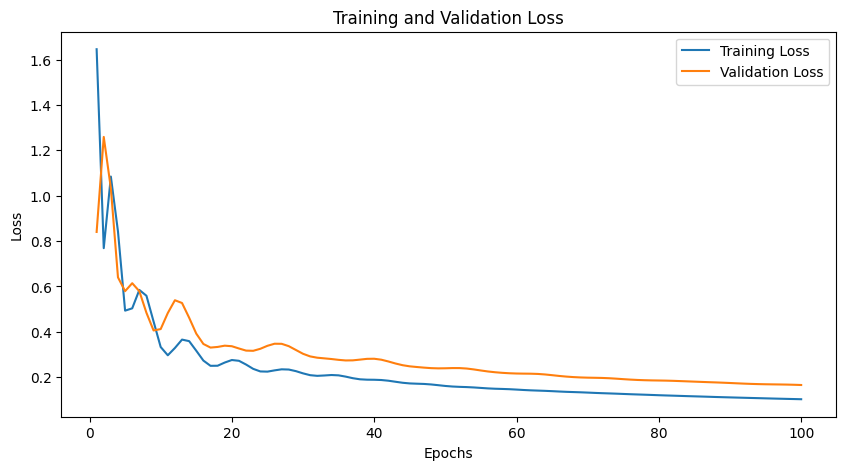

Accuracy: 91.66666666666666%


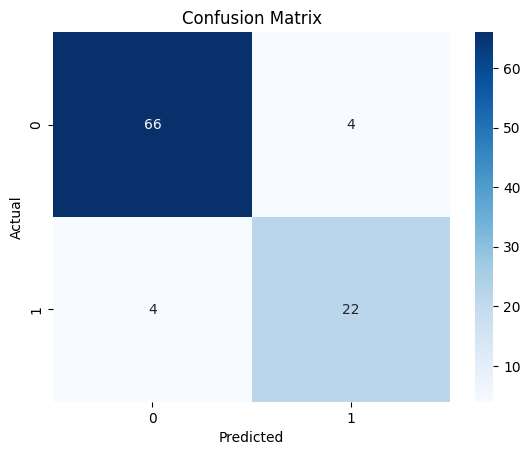

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

data = np.load('/content/features.npz')
X = data['features']
y = data['labels']

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("The features or labels are empty. Please check the data preprocessing step.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

class WakeWordModel(nn.Module):
    def __init__(self):
        super(WakeWordModel, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = WakeWordModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Accuracy: {accuracy * 100}%')

conf_matrix = confusion_matrix(y_test.cpu(), predicted.cpu())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Ok lets enhance our results by addding some augmentation techniques

### Adding augmentation techniques

In [ ]:
import librosa
import numpy as np
import os

def preprocess_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)

    y = librosa.util.normalize(y)

    y_trimmed, _ = librosa.effects.trim(y)

    return y_trimmed, sr

def extract_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    return np.mean(mfccs.T, axis=0)

def data_augmentation(y, sr):
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

    y_speed = librosa.effects.time_stretch(y, rate=1.5)

    noise = np.random.randn(len(y))
    y_noisy = y + 0.005 * noise

    return y_shifted, y_speed, y_noisy

audio_dir = "/content/alexa_data/"
features = []
labels = []

for label_type in ['positive', 'negative']:
    class_label = 1 if label_type == 'positive' else 0
    subdir = os.path.join(audio_dir, label_type)

    for file_name in os.listdir(subdir):
        if file_name.endswith(".wav") and not file_name.startswith("._"):
            audio_path = os.path.join(subdir, file_name)

            y, sr = preprocess_audio(audio_path)
            y_shifted, y_speed, y_noisy = data_augmentation(y, sr)

            mfccs_original = extract_features(y, sr)
            mfccs_shifted = extract_features(y_shifted, sr)
            mfccs_speed = extract_features(y_speed, sr)
            mfccs_noisy = extract_features(y_noisy, sr)

            features.append(mfccs_original)
            features.append(mfccs_shifted)
            features.append(mfccs_speed)
            features.append(mfccs_noisy)

            labels.extend([class_label] * 4)

if features:
    features = np.array(features)
    labels = np.array(labels)
    np.savez('/content/features.npz', features=features, labels=labels)
    print(f"Extracted features for {len(features)} augmented files.")
else:
    print("No features or labels extracted. Please check the input data.")


Extracted features for 1904 augmented files.


Features shape: (1904, 20)
Labels shape: (1904,)
X_train shape: torch.Size([1713, 20])
X_test shape: torch.Size([191, 20])
y_train shape: torch.Size([1713])
y_test shape: torch.Size([191])
Epoch 1/2500, Training Loss: 2.838853120803833, Validation Loss: 2.7439234256744385
Epoch 2/2500, Training Loss: 2.6297950744628906, Validation Loss: 2.5337488651275635
Epoch 3/2500, Training Loss: 2.4346752166748047, Validation Loss: 2.337768316268921
Epoch 4/2500, Training Loss: 2.2553255558013916, Validation Loss: 2.157926321029663
Epoch 5/2500, Training Loss: 2.0933892726898193, Validation Loss: 1.9959875345230103
Epoch 6/2500, Training Loss: 1.950177550315857, Validation Loss: 1.853337049484253
Epoch 7/2500, Training Loss: 1.8264176845550537, Validation Loss: 1.7307024002075195
Epoch 8/2500, Training Loss: 1.7221437692642212, Validation Loss: 1.6280081272125244
Epoch 9/2500, Training Loss: 1.6366362571716309, Validation Loss: 1.544326663017273
Epoch 10/2500, Training Loss: 1.5685480833053589, Va

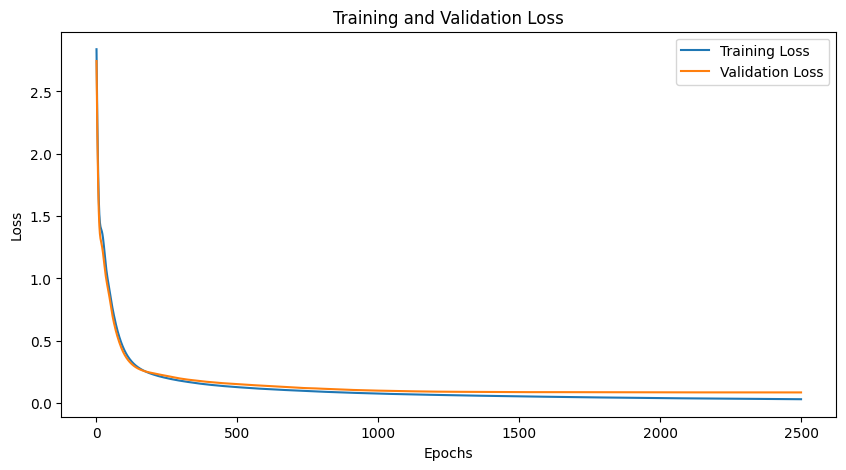

Accuracy: 96.8586387434555%


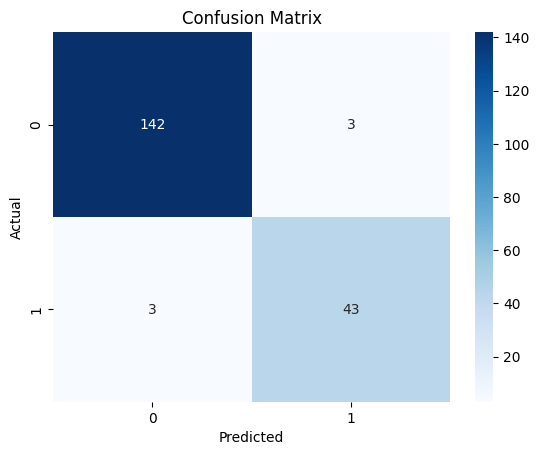

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

data = np.load('/content/features.npz')
X = data['features']
y = data['labels']

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("The features or labels are empty. Please check the data preprocessing step.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

class WakeWordModel(nn.Module):
    def __init__(self):
        super(WakeWordModel, self).__init__()
        self.fc1 = nn.Linear(20, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = WakeWordModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

num_epochs = 2500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Accuracy: {accuracy * 100}%')

conf_matrix = confusion_matrix(y_test.cpu(), predicted.cpu())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
